In [1]:
import torch, torchvision
import matplotlib.pyplot as plt

In [2]:
from torchvision.transforms import v2
training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        v2.RandomResizedCrop(size=32, scale=[0.85,1.0], antialias=False),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ])
)

test_data = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2])

batch_size = 64


# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=True, 
    num_workers=4)
val_dataloader = torch.utils.data.DataLoader(validation_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=False, 
    num_workers=4)

/soft/datascience/conda/2023-10-04/mconda3/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/soft/datascience/conda/2023-10-04/mconda3/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

Files already downloaded and verified
Files already downloaded and verified


In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

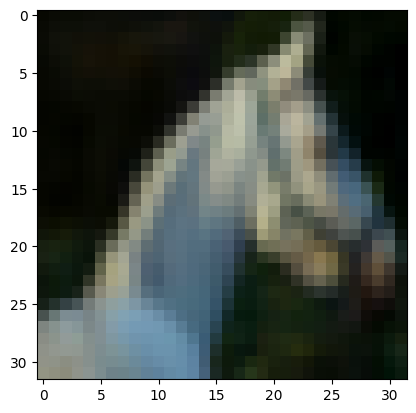

In [4]:
batch, (X, Y) = next(enumerate(train_dataloader))
plt.imshow(X[0].cpu().permute((1,2,0)));

In [5]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)

In [6]:
from torch import nn


class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )
    
    def forward(self, inputs):


        return self.downsample(self.norm(inputs))
    
class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels, 
                                     groups=in_channels,
                                     kernel_size=[5,5],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=2*in_channels,
                                     kernel_size=1)
        
        self.conv3 = nn.Conv2d(in_channels=2*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1)

#         self.conv4 = nn.Conv2d(in_channels=4*in_channels, 
#                                      out_channels=in_channels,
#                                      kernel_size=1
#                                      )
        
        self.dropout = nn.Dropout(p=0.5)  ## Added a dropout with 50% probability
        
        
        
    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)
        
        x = torch.nn.functional.gelu(x)
        
        # x = self.conv4(x)
        
        x = self.dropout(x)

        # This makes it a residual network:
        return x + inputs
    
class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)
        
        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters
        
        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters, 
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]
            


        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.ReLU(),  # Activation function
            nn.Dropout(p=0.5), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10, 
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x



        # x = self.norm2(x)
        # x = self.bottleneck(x)

        # # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        # return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,10))


In [7]:
model = Classifier(64, 3, 2)

model.cuda()

from torchinfo import summary

print(summary(model, input_size=(batch_size, 3, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [64, 10]                  --
├─Conv2d: 1-1                            [64, 64, 32, 32]          256
├─LayerNorm: 1-2                         [64, 64, 32, 32]          131,072
├─Sequential: 1-3                        [64, 256, 8, 8]           --
│    └─ConvNextBlock: 2-1                [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-1                  [64, 64, 32, 32]          1,664
│    │    └─LayerNorm: 3-2               [64, 64, 32, 32]          131,072
│    │    └─Conv2d: 3-3                  [64, 128, 32, 32]         8,320
│    │    └─Conv2d: 3-4                  [64, 64, 32, 32]          8,256
│    │    └─Dropout: 3-5                 [64, 64, 32, 32]          --
│    └─ConvNextBlock: 2-2                [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-6                  [64, 64, 32, 32]          1,664
│    │    └─LayerNorm: 3-7               [64, 64, 32, 32]     

In [8]:
def evaluate(dataloader, model, loss_fn, val_bar):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:

            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            val_bar.update()
            
    loss /= num_batches
    correct /= (size*batch_size)
    
    accuracy = 100*correct
    return accuracy, loss

In [9]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
           
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()      

        progress_bar.update()


In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)

In [11]:
from tqdm.notebook import tqdm


epochs = 40
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)
    
    # checking on the training loss and accuracy once per epoch
        
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)

        print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
        train_loss.append(loss)
        train_accuracy.append(acc)
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
    
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")
        val_loss.append(loss_val)
        val_accuracy.append(acc_val)

Train Epoch 0:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 0: training loss: 1.643, accuracy: 37.817


Validate Epoch 0:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0: validation loss: 1.658, accuracy: 36.833


Train Epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1: training loss: 1.492, accuracy: 44.995


Validate Epoch 1:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1: validation loss: 1.524, accuracy: 43.621


Train Epoch 2:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 2:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2: training loss: 1.301, accuracy: 53.117


Validate Epoch 2:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.333, accuracy: 51.642


Train Epoch 3:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 3:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3: training loss: 1.160, accuracy: 57.375


Validate Epoch 3:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.206, accuracy: 55.772


Train Epoch 4:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 4:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 4: training loss: 1.090, accuracy: 60.915


Validate Epoch 4:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4: validation loss: 1.136, accuracy: 59.066


Train Epoch 5:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 5: training loss: 0.951, accuracy: 66.560


Validate Epoch 5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5: validation loss: 0.998, accuracy: 64.570


Train Epoch 6:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 6:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 6: training loss: 0.871, accuracy: 69.130


Validate Epoch 6:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6: validation loss: 0.927, accuracy: 66.779


Train Epoch 7:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 7:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 7: training loss: 0.841, accuracy: 70.690


Validate Epoch 7:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7: validation loss: 0.900, accuracy: 68.322


Train Epoch 8:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 8:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 8: training loss: 0.751, accuracy: 73.400


Validate Epoch 8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8: validation loss: 0.810, accuracy: 70.939


Train Epoch 9:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 9:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 9: training loss: 0.714, accuracy: 74.647


Validate Epoch 9:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9: validation loss: 0.776, accuracy: 72.174


Train Epoch 10:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 10: training loss: 0.655, accuracy: 77.448


Validate Epoch 10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10: validation loss: 0.719, accuracy: 75.259


Train Epoch 11:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 11:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 11: training loss: 0.617, accuracy: 78.990


Validate Epoch 11:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11: validation loss: 0.694, accuracy: 75.508


Train Epoch 12:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 12:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 12: training loss: 0.558, accuracy: 80.725


Validate Epoch 12:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12: validation loss: 0.640, accuracy: 77.379


Train Epoch 13:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 13:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 13: training loss: 0.606, accuracy: 78.752


Validate Epoch 13:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13: validation loss: 0.688, accuracy: 75.488


Train Epoch 14:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 14:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 14: training loss: 0.565, accuracy: 80.802


Validate Epoch 14:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14: validation loss: 0.651, accuracy: 77.199


Train Epoch 15:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 15: training loss: 0.489, accuracy: 83.337


Validate Epoch 15:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15: validation loss: 0.591, accuracy: 79.389


Train Epoch 16:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 16:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 16: training loss: 0.528, accuracy: 81.490


Validate Epoch 16:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16: validation loss: 0.642, accuracy: 77.687


Train Epoch 17:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 17:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 17: training loss: 0.510, accuracy: 82.350


Validate Epoch 17:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17: validation loss: 0.623, accuracy: 78.384


Train Epoch 18:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 18:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 18: training loss: 0.499, accuracy: 82.950


Validate Epoch 18:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18: validation loss: 0.603, accuracy: 78.871


Train Epoch 19:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 19:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 19: training loss: 0.485, accuracy: 83.230


Validate Epoch 19:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19: validation loss: 0.598, accuracy: 79.479


Train Epoch 20:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 20: training loss: 0.451, accuracy: 84.453


Validate Epoch 20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20: validation loss: 0.572, accuracy: 80.324


Train Epoch 21:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 21:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 21: training loss: 0.401, accuracy: 86.237


Validate Epoch 21:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 21: validation loss: 0.525, accuracy: 81.967


Train Epoch 22:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 22:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 22: training loss: 0.424, accuracy: 85.242


Validate Epoch 22:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 22: validation loss: 0.549, accuracy: 81.141


Train Epoch 23:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 23:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 23: training loss: 0.477, accuracy: 83.447


Validate Epoch 23:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 23: validation loss: 0.609, accuracy: 79.449


Train Epoch 24:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 24:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 24: training loss: 0.468, accuracy: 83.742


Validate Epoch 24:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 24: validation loss: 0.585, accuracy: 79.668


Train Epoch 25:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 25: training loss: 0.404, accuracy: 86.282


Validate Epoch 25:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 25: validation loss: 0.527, accuracy: 82.096


Train Epoch 26:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 26:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 26: training loss: 0.423, accuracy: 85.605


Validate Epoch 26:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 26: validation loss: 0.543, accuracy: 80.922


Train Epoch 27:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 27:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 27: training loss: 0.449, accuracy: 84.915


Validate Epoch 27:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 27: validation loss: 0.580, accuracy: 80.066


Train Epoch 28:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 28:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 28: training loss: 0.428, accuracy: 85.290


Validate Epoch 28:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 28: validation loss: 0.574, accuracy: 80.683


Train Epoch 29:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 29:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 29: training loss: 0.375, accuracy: 87.150


Validate Epoch 29:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 29: validation loss: 0.513, accuracy: 82.146


Train Epoch 30:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 30:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 30: training loss: 0.401, accuracy: 86.127


Validate Epoch 30:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 30: validation loss: 0.557, accuracy: 80.981


Train Epoch 31:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 31:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 31: training loss: 0.390, accuracy: 86.377


Validate Epoch 31:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 31: validation loss: 0.538, accuracy: 81.290


Train Epoch 32:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 32:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 32: training loss: 0.393, accuracy: 86.498


Validate Epoch 32:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 32: validation loss: 0.540, accuracy: 81.379


Train Epoch 33:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 33:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 33: training loss: 0.400, accuracy: 86.280


Validate Epoch 33:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 33: validation loss: 0.559, accuracy: 80.902


Train Epoch 34:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 34:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 34: training loss: 0.398, accuracy: 86.347


Validate Epoch 34:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 34: validation loss: 0.557, accuracy: 81.031


Train Epoch 35:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 35:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 35: training loss: 0.382, accuracy: 86.892


Validate Epoch 35:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 35: validation loss: 0.530, accuracy: 81.608


Train Epoch 36:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 36:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 36: training loss: 0.402, accuracy: 86.045


Validate Epoch 36:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 36: validation loss: 0.550, accuracy: 81.031


Train Epoch 37:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 37:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 37: training loss: 0.373, accuracy: 87.110


Validate Epoch 37:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 37: validation loss: 0.532, accuracy: 81.867


Train Epoch 38:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 38:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 38: training loss: 0.411, accuracy: 85.888


Validate Epoch 38:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 38: validation loss: 0.572, accuracy: 80.772


Train Epoch 39:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 39:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 39: training loss: 0.419, accuracy: 85.480


Validate Epoch 39:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 39: validation loss: 0.568, accuracy: 80.305


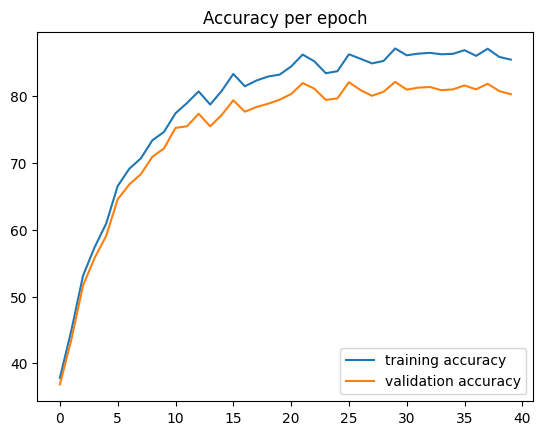

In [12]:
plt.plot(train_accuracy, label='training accuracy')
plt.plot(val_accuracy, label= 'validation accuracy')
plt.title('Accuracy per epoch')
plt.legend();

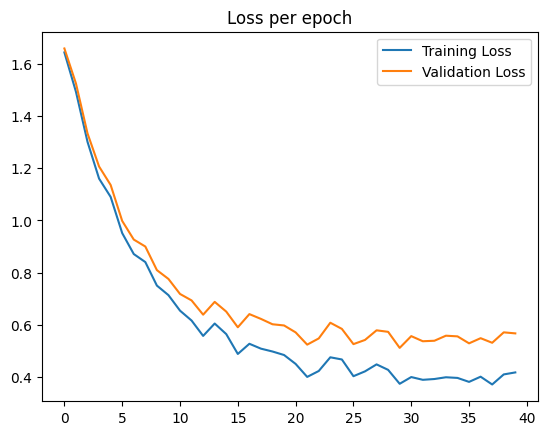

In [13]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label= 'Validation Loss')
plt.title('Loss per epoch')
plt.legend();

### So I got up to the validation accuracy of ~80% for the following reasons:
 - Lowered the value of filter(kernel) size from 7 to 5 which captured smaller details from the images.
 - Added few more dense layers.
 - At first the model was overfitting(training accuracy > 90% and validation accuracy < 80%) so I added `DropOut` layers between the dense layers as well as increased the value of `weight_decay` parameter to increase the effect of `L2-Regularization`. 